In [2]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, \
    precision_score, recall_score, precision_recall_curve, average_precision_score, \
    confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from pdpbox import pdp
from sklearn.calibration import calibration_curve 
from sklearn.base import clone 
%matplotlib inline 

# Load Data

In [3]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [4]:
# load data 
df = pd.read_csv(os.path.join(DATAFOLDER, "data_for_model/appeals_data_final.csv"))
df.set_index('idnAppeal', inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 242466 entries, 4657002.0 to 5021568.0
Data columns (total 43 columns):
idncase                                242466 non-null int64
idnproceeding                          242466 non-null int64
nat_grouped                            242466 non-null object
lang_grouped                           242466 non-null object
ij_code_grouped                        242466 non-null object
Male_judge                             226481 non-null float64
Year_Appointed_SLR                     226481 non-null float64
Year_College_SLR                       226481 non-null float64
Year_Law_school_SLR                    226481 non-null float64
Government_Years_SLR                   226481 non-null float64
Govt_nonINS_SLR                        226481 non-null float64
INS_Years_SLR                          226481 non-null float64
Military_Years_SLR                     226481 non-null float64
NGO_Years_SLR                          226481 non-null float64
P

# Data Pipelines

In [5]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'median', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'median': 
        val = col.median() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [6]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [7]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [8]:
# method to subset and transform data (impute, convert, dummify)

def transform_features(df, appeals_df, cat_features, num_features, impute_methods): 
    """ Impute, convert and dummify features 
        TODO: save cat_feature_values to pickle so that we don't have to read df 
    """  
    
    # makes sure dummified values match 
    cat_feature_values = dict([(f, [str(x) for x in appeals_df[f].dropna().unique().tolist()]) for f in cat_features])
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X = data_pipeline.fit_transform(df)
    
    return X

# method to split train-test and transform features 

def get_model_data(df, appeals_df, label, cat_features, num_features, impute_methods, test_size=0.2, print_summary=False): 
    """ Subsets features used, splits into train-test, and transforms features """
    
    # subsets features we are interested in 
    data = df[cat_features + num_features + [label]].copy() 
    appeals_df = appeals_df[cat_features + num_features].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=44)

    # transform features
    X_train = transform_features(x_train, appeals_df, cat_features, num_features, impute_methods)
    X_test = transform_features(x_test, appeals_df, cat_features, num_features, impute_methods)

    if print_summary:
        print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [9]:
# method to return model evaluation metrics 
def evaluate_model(truth, pred, print_cm=False): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(truth, (pred>0.5).astype(int))
    recall = recall_score(truth, (pred>0.5).astype(int))
    if print_cm: 
        print("Confusion Matrix:")
        print(confusion_matrix(truth, (pred>0.5).astype(int)))
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss, 
               'Precision': precision, 'Recall': recall}
    return metrics

In [10]:
# method to plot ROC 

def plot_roc(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot ROC curve """
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    if model_name is not None: 
        plt.plot(fpr, tpr, label= '{0} (AUC = {1:.3f})'.format(model_name, roc_auc)) 
    else: 
        plt.plot(fpr, tpr, label= 'AUC:{0:.3f}'.format(roc_auc)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('ROC')
    plt.legend(loc="lower right")   

In [11]:
# method to plot precision-recall curve 

def plot_precision_recall(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot precision-recall curve
        Code borrowed from http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """    
    precision, recall, _ = precision_recall_curve(truth, pred)
    average_precision = average_precision_score(truth, pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b', 
                     label='Avg Precision:{0:.3f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('Precision-Recall curve') 
    plt.legend(loc='lower right')

In [12]:
# method to train a model, output results, and plot AUC 

def train_model(model, X_train, y_train, X_test, y_test, print_metrics=True, print_charts=False, 
                sample_weight=None, print_cm=False):
    if sample_weight is not None: 
        model.fit(X_train, y_train.values.ravel(), sample_weight)
    else: 
        model.fit(X_train, y_train.values.ravel())
    truth = y_test.values.ravel()
    pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(truth, pred, print_cm)
    try: 
        fi, cfi = get_feature_importances(model, X_train)
    except AttributeError: 
        fi, cfi = None, None 
    
    if print_metrics: 
        print(metrics)
    if print_charts: 
        plot_metrics(truth, pred)
    return model, metrics, fi, cfi, truth, pred   

In [13]:
# method to plot ROC and Precision-Recall

def plot_metrics(truth, pred): 
    """ Plots ROC and Precision-Recall curves """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_roc(truth, pred)
    plt.subplot(1, 2, 2)
    plot_precision_recall(truth, pred) 

In [14]:
# method to get feature importances 

def get_feature_importances(model, X_train):
    
    """ Takes model and train data as inputs, outputs regular and collapsed feature importances """
    
    # get 'regular' feature importances 
    fi = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # get 'collapsed' feature importances (dummy variables of parent feature aggregated as one)
    cfi = pd.DataFrame(fi).reset_index().rename(columns={'index': 'feature', 0: 'importance'})
    cfi['parent_feature'] = cfi['feature'].apply(lambda x: x.split(':::')[0])
    cfi = cfi.groupby('parent_feature')['importance'].sum().sort_values(ascending=False) 
    
    return fi, cfi 

# Aggregate Model

### Baseline Models 

Training Data: (193972, 130) | Test Data: (48494, 130)
Confusion Matrix:
[[31418  1323]
 [14033  1720]]
{'Accuracy': 0.6833422691466986, 'ROC AUC': 0.6658744389030938, 'Log Loss': 0.5909904245756051, 'Precision': 0.5652316792638843, 'Recall': 0.10918555195835714}


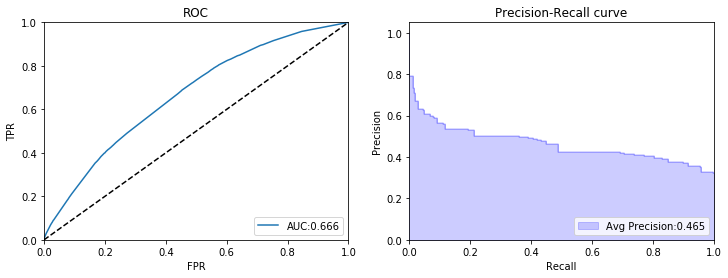

In [14]:
# baseline 1: nationality only 
CAT_FEATURES = ['nat_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS, 
                                                  print_summary=True) 
nat_model, nat_metrics, _, _, nat_truth, nat_pred  = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                  print_metrics=True, print_charts=True, print_cm=True)

Training Data: (193972, 369) | Test Data: (48494, 369)
Confusion Matrix:
[[31780   961]
 [14777   976]]
{'Accuracy': 0.6754650059801213, 'ROC AUC': 0.6255989297363183, 'Log Loss': 0.6088988518020986, 'Precision': 0.5038719669592153, 'Recall': 0.0619564527391608}


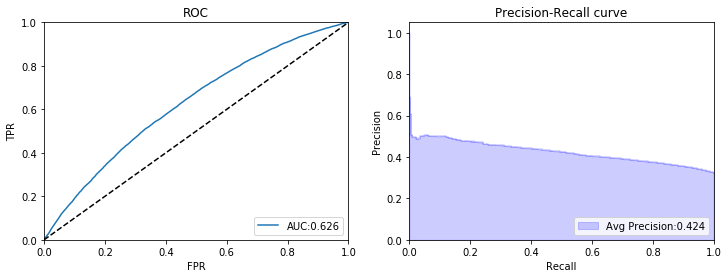

In [15]:
# baseline 2: judge only 
CAT_FEATURES = ['ij_code_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
ij_model, ij_metrics, _, _, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                               print_metrics=True, print_charts=True, print_cm=True)

Training Data: (193972, 499) | Test Data: (48494, 499)
Confusion Matrix:
[[28870  3871]
 [10437  5316]]
{'Accuracy': 0.7049531900853714, 'ROC AUC': 0.701441945791493, 'Log Loss': 0.7696102244225282, 'Precision': 0.5786437357135082, 'Recall': 0.3374595315178061}


parent_feature
ij_code_grouped    0.56737
nat_grouped        0.43263
Name: importance, dtype: float64

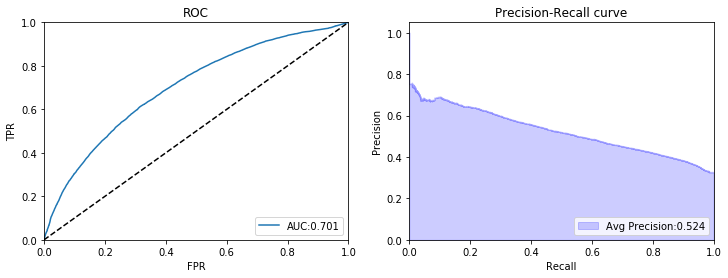

In [16]:
# baseline 3: nat + judge 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
nat_ij_model, nat_ij_metrics, _, nat_ij_cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                print_metrics=True, print_charts=True, print_cm=True)
nat_ij_cfi

Training Data: (193972, 500) | Test Data: (48494, 500)
Confusion Matrix:
[[28069  4672]
 [ 7849  7904]]
{'Accuracy': 0.7418031096630511, 'ROC AUC': 0.7658298030269455, 'Log Loss': 1.0955408708101284, 'Precision': 0.628498727735369, 'Recall': 0.5017456992318924}


parent_feature
ij_code_grouped        0.430265
datAppealFiled_year    0.313652
nat_grouped            0.256084
Name: importance, dtype: float64

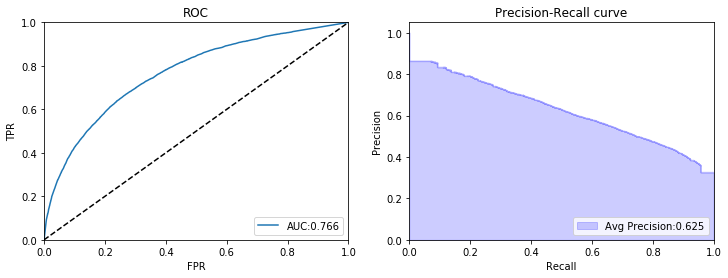

In [17]:
# baseline 4: nat + judge + appeal year 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
nat_ij_year_model, nat_ij_year_metrics, _, nat_ij_year_cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test,
                                                                               print_metrics=True, print_charts=True, print_cm=True)
nat_ij_year_cfi

In [16]:
# full model 
FULL_CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'lang_grouped', 'case_type_string', 'Male_judge',
                     'strCustody', 'strProbono', 'original_dec_string', 'base_city_code', 'hearing_loc_match_base']
FULL_NUM_FEATURES = ['datAppealFiled_year', 'comp_year_month', 'lawyer', 'defensive', 'affirmative',
                     'oral', 'written', 'comp_year', 'Year_Appointed_SLR', 'Year_College_SLR',
                     'Year_Law_school_SLR', 'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 
                     'Military_Years_SLR', 'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR',
                     'judge_missing_bio', 'appeal_days_elapsed_since_comp_date', 'comp_days_elasped_since_input_date', 
                     'input_days_elapsed_since_osc_date', 'years_since_judge_appointment', 'years_since_law_school', 
                     'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat'] 

FULL_IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'Male_judge': 'none', 
                       'original_dec_string': 'none', 'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 
                       'written': 'zero', 'Year_Appointed_SLR': 'median', 'Year_College_SLR': 'median',
                       'Year_Law_school_SLR': 'median', 'Government_Years_SLR': 'median', 
                       'Govt_nonINS_SLR': 'median', 'INS_Years_SLR': 'median', 'Military_Years_SLR': 'median',
                       'NGO_Years_SLR': 'median', 'Privateprac_Years_SLR': 'median', 'Academia_Years_SLR': 'median',
                       'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'} 

Training Data: (193972, 704) | Test Data: (48494, 704)
Confusion Matrix:
[[29919  2822]
 [ 7264  8489]]
{'Accuracy': 0.7920155070730399, 'ROC AUC': 0.8403613258837886, 'Log Loss': 0.6125752284174869, 'Precision': 0.7505083546989656, 'Recall': 0.5388814828921475}


parent_feature
nat_grouped                            0.097833
appeal_days_elapsed_since_comp_date    0.093665
comp_year_month                        0.070223
comp_days_elasped_since_input_date     0.068407
lang_grouped                           0.065299
ij_code_grouped                        0.064423
input_days_elapsed_since_osc_date      0.062389
datAppealFiled_year                    0.050643
base_city_code                         0.043185
last_10_appeal_grant_by_judge_nat      0.040157
last_10_appeal_grant_by_judge          0.038952
comp_year                              0.037614
years_since_law_school                 0.030383
years_since_judge_appointment          0.030081
original_dec_string                    0.024790
strCustody                             0.019394
Year_College_SLR                       0.016626
Year_Law_school_SLR                    0.016295
Year_Appointed_SLR                     0.015300
Privateprac_Years_SLR                  0.012610
Government_Years_SLR     

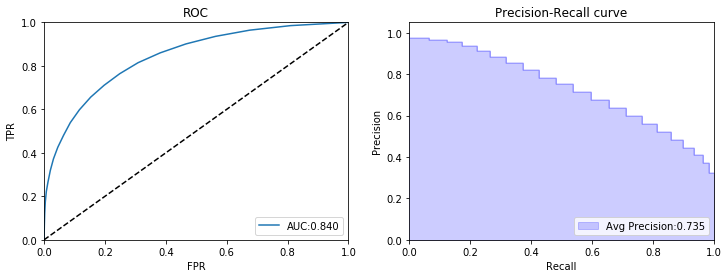

In [17]:
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, 
                                                  impute_methods = FULL_IMPUTE_METHODS, print_summary=True) 
rf_model, rf_metrics, rf_fi, rf_cfi, rf_truth, rf_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True, print_cm=True)
rf_cfi

In [19]:
baseline_comparison = {'Nationality Only': nat_metrics, 
                       'Judge Only': ij_metrics, 
                       'Nat + Judge': nat_ij_metrics, 
                       'Nat + Judge + Appeal Year': nat_ij_year_metrics, 
                       'Full Model': rf_metrics}

pd.DataFrame.from_dict(baseline_comparison, orient='index')

,Accuracy,ROC AUC,Log Loss,Precision,Recall
Full Model,0.792016,0.840361,0.612575,0.750508,0.538881
Judge Only,0.675465,0.625599,0.608899,0.503872,0.061956
Nat + Judge,0.704953,0.701442,0.769610,0.578644,0.337460
Nat + Judge + Appeal Year,0.741803,0.765830,1.095541,0.628499,0.501746
Nationality Only,0.683342,0.665874,0.590990,0.565232,0.109186


### Try Other Tree-Based Models

#### Gradient Boosting

Confusion Matrix:
[[30616  2125]
 [11458  4295]]
{'Accuracy': 0.7199034932156555, 'ROC AUC': 0.736082659822967, 'Log Loss': 0.5613303621166984, 'Precision': 0.6690031152647975, 'Recall': 0.2726464800355488}


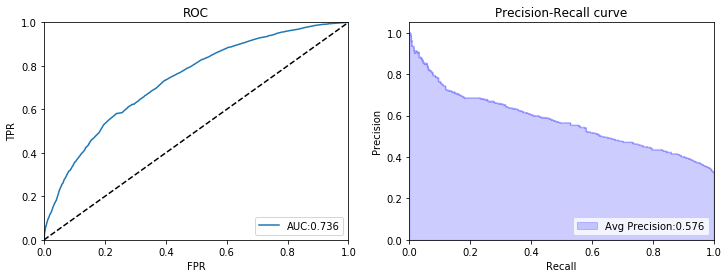

In [20]:
MODEL = (GradientBoostingClassifier(loss='deviance', learning_rate=.1, n_estimators=20, random_state=44))
X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS)
gb_model, gb_metrics, gb_fi, gb_cfi, gb_truth, gb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True, print_cm=True)

#### XGBoost 

Confusion Matrix:
[[29699  3042]
 [10570  5183]]
{'Accuracy': 0.7193054810904442, 'ROC AUC': 0.7309368462146715, 'Log Loss': 0.5645532005204144, 'Precision': 0.6301519756838906, 'Recall': 0.3290166952326541}


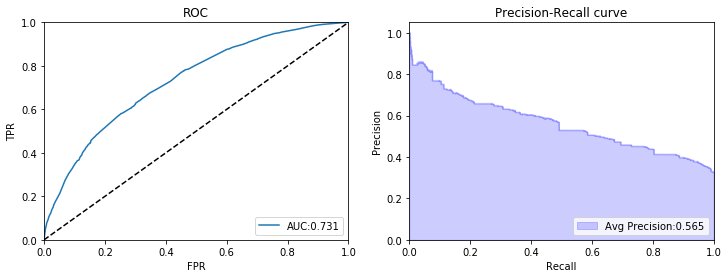

In [21]:
MODEL = (XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=20, seed=44))
X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS)
xgb_model, xgb_metrics, xgb_fi, xgb_cfi, xgb_truth, xgb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                           print_metrics=True, print_charts=True, print_cm=True)

#### Logistic Regression 

Confusion Matrix:
[[30280  2461]
 [11470  4283]]
{'Accuracy': 0.7127273477131192, 'ROC AUC': 0.7303016150992858, 'Log Loss': 0.5571351745897823, 'Precision': 0.6350830367734283, 'Recall': 0.27188472037072303}


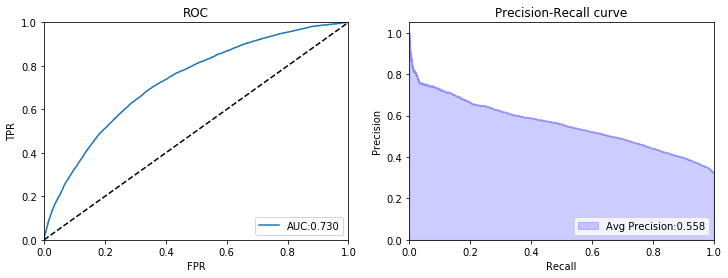

In [22]:
MODEL = (LogisticRegression(penalty='l2', C=1))
X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS) 
lr_model, lr_metrics, lr_fi, lr_cfi, lr_truth, lr_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True, print_cm=True)

#### Algorithm Comparison (out-of-the-box)

In [23]:
algo_comparison = {'Random Forest': rf_metrics, 
                   'Gradient Boosting': gb_metrics, 
                   'XGBoost': xgb_metrics, 
                   'Logistic Regression': lr_metrics}

pd.DataFrame.from_dict(algo_comparison, orient='index').sort_values(by='ROC AUC', ascending=False)

,Accuracy,ROC AUC,Log Loss,Precision,Recall
Random Forest,0.792016,0.840361,0.612575,0.750508,0.538881
Gradient Boosting,0.719903,0.736083,0.561330,0.669003,0.272646
XGBoost,0.719305,0.730937,0.564553,0.630152,0.329017
Logistic Regression,0.712727,0.730302,0.557135,0.635083,0.271885


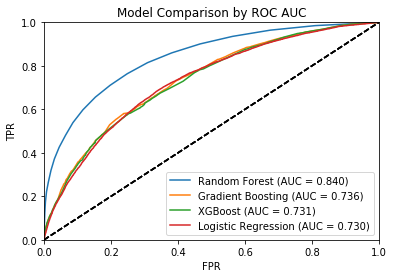

In [25]:
# plot all ROC in a single chart 
plot_roc(rf_truth, rf_pred, 'Random Forest')
plot_roc(gb_truth, gb_pred, 'Gradient Boosting')
plot_roc(xgb_truth, xgb_pred, 'XGBoost')
plot_roc(lr_truth, lr_pred, 'Logistic Regression')
plt.title('Model Comparison by ROC AUC'); 

Since Random Forest outperforms other algorithms significantly in accuracy and ROC AUC out-of-the-box, we will move forward with Random Forest and tune it to get our best model.  

### Tune Random Forest 

In [26]:
### WARNING: TAKES A WHILE TO RUN ### 

# define search scope 
max_features = ['sqrt'] # in previous iterations sqrt always wins 
max_depth = list(np.arange(60, 140, 20))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2] # in previous iterations higher min samples always lose 

# construct param grid 
param_grid = {'max_features': max_features, 'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# run randomized search cv 
X_train, _, y_train, _ = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                        num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS) 
rf_clf = RandomForestClassifier(n_estimators=20, random_state=44)
rf_gridsearch = GridSearchCV(rf_clf, param_grid, scoring=['roc_auc', 'accuracy', 'neg_log_loss'], refit='roc_auc')
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=44, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt'], 'max_depth': [60, 80, 100, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['roc_auc', 'accuracy', 'neg_log_loss'], verbose=0)

In [30]:
print(rf_gridsearch.best_params_)

{'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [27]:
def evaluate_search_cv(cv_object): 
    """ Print results for randomized search cv """
    rename_cols = {'param_max_depth': 'max_depth', 
                   'param_max_features': 'max_features', 
                   'param_min_samples_leaf': 'min_samples_leaf', 
                   'param_min_samples_split': 'min_samples_split', 
                   'mean_test_roc_auc': 'roc_auc', 
                   'mean_test_accuracy': 'accuracy', 
                   'mean_train_neg_log_loss': 'neg_log_loss'}
    results = pd.DataFrame(cv_object.cv_results_)
    results.rename(columns=rename_cols, inplace=True)
    results = results[['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 
                       'roc_auc', 'accuracy', 'neg_log_loss']]
    return results.sort_values(by='roc_auc', ascending=False)

In [31]:
# save grid search results 
gridsearch_results = evaluate_search_cv(rf_gridsearch)
gridsearch_results.to_csv('gridsearch_results.csv', index=False)

In [33]:
# reload search results from csv
gridsearch_results = pd.read_csv('gridsearch_results.csv')
gridsearch_results.head()

,max_depth,max_features,min_samples_leaf,min_samples_split,roc_auc,accuracy,neg_log_loss
0,60.0,sqrt,1,2,0.825572,0.780071,-0.133421
1,120.0,sqrt,1,5,0.825555,0.781242,-0.224127
2,NaN,sqrt,1,5,0.825555,0.781242,-0.224127
3,100.0,sqrt,1,5,0.825410,0.781458,-0.224184
4,80.0,sqrt,1,5,0.825235,0.781572,-0.224461


Confusion Matrix:
[[29912  2829]
 [ 6770  8983]]
{'Accuracy': 0.8020579865550377, 'ROC AUC': 0.8553543826685364, 'Log Loss': 0.4430359137045242, 'Precision': 0.7604977988486286, 'Recall': 0.5702405890941408}


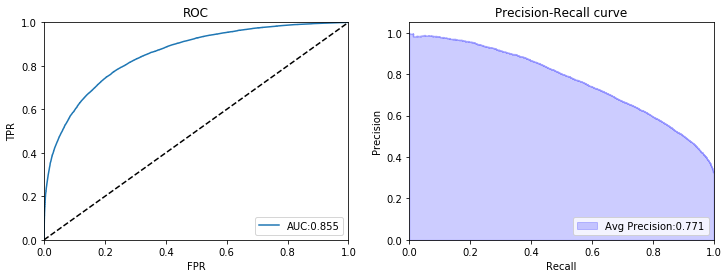

In [18]:
# retrain with best params on 100 trees 
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS) 
rf_best_model, rf_best_metrics, rf_best_fi, rf_best_cfi, rf_best_truth, rf_best_pred = train_model(
    MODEL, X_train, y_train, X_test, y_test, print_metrics=True, print_charts=True, print_cm=True)

In [35]:
algo_comparison_tuned = {'Random Forest (Tuned + More Trees)': rf_best_metrics,
                         'Random Forest': rf_metrics} 

pd.DataFrame.from_dict(algo_comparison_tuned, orient='index').sort_values(by='ROC AUC', ascending=False)

,Accuracy,ROC AUC,Log Loss,Precision,Recall
Random Forest (Tuned + More Trees),0.802058,0.855354,0.443036,0.760498,0.570241
Random Forest,0.792016,0.840361,0.612575,0.750508,0.538881


In [36]:
# check feature importances 
rf_best_fi.head(20)

appeal_days_elapsed_since_comp_date    0.094593
comp_year_month                        0.070178
comp_days_elasped_since_input_date     0.067002
input_days_elapsed_since_osc_date      0.060959
datAppealFiled_year                    0.049302
last_10_appeal_grant_by_judge_nat      0.040085
last_10_appeal_grant_by_judge          0.038260
comp_year                              0.038135
years_since_law_school                 0.030743
years_since_judge_appointment          0.029350
Year_College_SLR                       0.016769
Year_Law_school_SLR                    0.016564
Year_Appointed_SLR                     0.015647
nat_grouped:::EL SALVADOR              0.013043
Government_Years_SLR                   0.012750
Privateprac_Years_SLR                  0.012436
INS_Years_SLR                          0.012241
Govt_nonINS_SLR                        0.009944
lang_grouped:::SP                      0.008618
lang_grouped:::CRE                     0.008318
dtype: float64

In [37]:
# check collapsed feature importances 
rf_best_cfi

parent_feature
nat_grouped                            0.098442
appeal_days_elapsed_since_comp_date    0.094593
comp_year_month                        0.070178
comp_days_elasped_since_input_date     0.067002
lang_grouped                           0.066282
ij_code_grouped                        0.065733
input_days_elapsed_since_osc_date      0.060959
datAppealFiled_year                    0.049302
base_city_code                         0.042166
last_10_appeal_grant_by_judge_nat      0.040085
last_10_appeal_grant_by_judge          0.038260
comp_year                              0.038135
years_since_law_school                 0.030743
years_since_judge_appointment          0.029350
original_dec_string                    0.024880
strCustody                             0.019325
Year_College_SLR                       0.016769
Year_Law_school_SLR                    0.016564
Year_Appointed_SLR                     0.015647
case_type_string                       0.012755
Government_Years_SLR     

In [38]:
# save model to pickle 
import pickle
model_pkl_fname = "aggregate_random_forest_vF.pkl"
with open(model_pkl_fname, 'wb') as file:  
    pickle.dump(rf_best_model, file)

### Probability Calibration

Probability calibration can sometimes be an issue for random forest. But it appears that our classifier is already well-calibrated, so we deem it unnecessary to proceed with calibration methods like Platt Scaling. 

In [39]:
y_pred_outofbox = rf_model.predict_proba(X_test)[:,1]
y_pred_best = rf_best_model.predict_proba(X_test)[:,1]
calibration_outofbox = calibration_curve(y_test, y_pred_outofbox, n_bins=10)
calibration_best = calibration_curve(y_test, y_pred_best, n_bins=10)

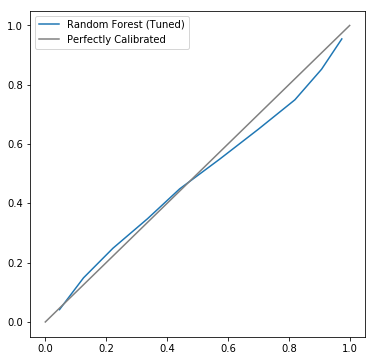

In [41]:
plt.figure(figsize=(6, 6))
plt.plot(calibration_best[0], calibration_best[1], label='Random Forest (Tuned)')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Perfectly Calibrated', color='grey')
plt.legend(loc='best');

# Sequential Models

Thus far we aggregated data across time as a single population from which we drew train and test samples from. This might not be the most realistic way to build a model that is used to predict future appeal outcomes (i.e. we do not have the luxury of using data from future appeals to inform the outcome of a current appeal). To more realistically assess the power of our predictive models, we will build a sequence of models: one model to predict each year's of appeals (by datAppealFiled_year) between 1991 and 2013 using data in preceeding years. In other words, we will only use data from 2000 and earlier to predict 2001's appeals, data from 2001 and earlier to predict 2002's appeals etc. 

In [20]:
def get_model_data_by_year(df, appeals_df, label, unique_id, cat_features, num_features, impute_methods, predict_year): 
    """ Generates features on data for years prior to predict_year """

    # add 'datAppealFiled_year' if not in num_features 
    if 'datAppealFiled_year' not in num_features: 
        num_features_ = num_features + ['datAppealFiled_year'] 
    else: 
        num_features_ = num_features 

    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) 
    data = df.set_index(unique_id)
    if label is not None: 
        data = data[cat_features + num_features_ + [label]].copy() 
    else: 
        data = data[cat_features + num_features].copy()

    # train test split 
    train_data = data[data['datAppealFiled_year'] < predict_year]
    test_data = data[data['datAppealFiled_year'] == predict_year]
    
    # return y=None if label is not passed (used for parsing data for pure predictions)
    if label is not None: 
        x_train, y_train = train_data.drop(label, axis=1).copy(), train_data[label].copy() 
        x_test, y_test = test_data.drop(label, axis=1).copy(), test_data[label].copy() 
    else: 
        x_train, y_train = train_data, None 
        x_test, y_test = test_data, None 

    # transform 
    X_train = transform_features(x_train, appeals_df, cat_features, num_features, impute_methods)
    X_test = transform_features(x_test, appeals_df, cat_features, num_features, impute_methods)

    return X_train, X_test, y_train, y_test 

In [21]:
def fit_sequential_models(df, model, label, cat_features, num_features, impute_methods, 
                          start_year, end_year, weight_decay=None, print_charts=False, print_metrics=True): 
    """ Trains a sequence of models using data from preceeding years to test on current year 
        TODO: modularize this if have time"""
    
    # initialize empty dictionary to collect all results 
    sequential_results = {}
    model_list = [] 
    
    # loop through each year to train model on data from preceeding years then test on current year 
    for i, year in enumerate(np.arange(start_year, end_year+1, 1)): 
        print("Training model to predict {} appeals...".format(year)) 
        result = {} # initialize empty dictionary to collect result for each year 
        model_list.append(clone(model)) # create a new copy of the model to train on new subset of data
        X_train, X_test, y_train, y_test = get_model_data_by_year(
            df, df, label='granted', unique_id='idnproceeding', cat_features=cat_features, num_features=num_features, 
            impute_methods=impute_methods, predict_year=year) 
        
        # weight samples 
        if weight_decay is not None:
            print(weight_decay)
            sample_weight = X_train['datAppealFiled_year'].apply(lambda x: weight_decay ** (year-x-1))
        else: 
            sample_weight = None 
        
        # datAppealFiled_year is included in X_train by default; remove if not in num_features
        if 'datAppealFiled_year' not in num_features: 
            X_train = X_train[[c for c in X_train.columns if c != 'datAppealFiled_year']]
            X_test = X_test[[c for c in X_train.columns if c != 'datAppealFiled_year']]
        else: 
            pass 
        
        # save results to dictionary 
        result['model'], result['metrics'], result['fi'], result['cfi'], result['truth'], result['pred'] = train_model(
            model_list[i], X_train, y_train, X_test, y_test, 
            print_charts=print_charts, print_metrics=print_metrics, sample_weight=sample_weight) 
        sequential_results[year] = result 
        
    # summarize model performance metrics 
    metric_summary = pd.DataFrame.from_dict(sequential_results, orient='index')['metrics'].apply(pd.Series)
    print(metric_summary)
    print("Average model performance metrics:")
    print(metric_summary.mean()) 
    plot_sequential_performance(metric_summary)
    
    # average feature importances 
    average_cfi = pd.DataFrame.from_dict(sequential_results, orient='index')['cfi']\
                              .apply(pd.Series).mean().sort_values(ascending=False)
    print("Average feature importances:")
    print(average_cfi)     
    
    return metric_summary, average_cfi, sequential_results 

In [22]:
def plot_sequential_performance(sequential_metrics):
    """ Plots AUC and Accuracy by test year """
    plt.figure(figsize=(10, 4))
    plt.plot(sequential_metrics['ROC AUC'])
    plt.plot(sequential_metrics['Accuracy'])
    plt.ticklabel_format(useOffset=False)
    plt.title('Accuracy and AUC of Sequential Models')
    plt.xlabel('Test Year')
    plt.legend(loc='best') 

It appears that building the model in a sequential way degraded the performance considerably. Perhaps even more surprisingly, accuracy appears to be worse in later years, which is somewhat counterintuitive given that later models had more data to train on. 

Training model to predict 1994 appeals...
{'Accuracy': 0.696111665004985, 'ROC AUC': 0.7601567236012797, 'Log Loss': 0.5781153714726865, 'Precision': 0.686013986013986, 'Recall': 0.4771400778210117}
Training model to predict 1995 appeals...
{'Accuracy': 0.7562522874222276, 'ROC AUC': 0.7791320518262487, 'Log Loss': 0.5232094969803878, 'Precision': 0.6863057324840764, 'Recall': 0.47888888888888886}
Training model to predict 1996 appeals...
{'Accuracy': 0.7336279630373644, 'ROC AUC': 0.7859386732237444, 'Log Loss': 0.54998248940824, 'Precision': 0.7407568508046977, 'Recall': 0.4530460228784251}
Training model to predict 1997 appeals...
{'Accuracy': 0.6667933130699089, 'ROC AUC': 0.7290601634931875, 'Log Loss': 0.6049930458444395, 'Precision': 0.665725806451613, 'Recall': 0.47813495511149723}
Training model to predict 1998 appeals...
{'Accuracy': 0.6712346477052359, 'ROC AUC': 0.7238937050178137, 'Log Loss': 0.5911013258824482, 'Precision': 0.6231578947368421, 'Recall': 0.3932248422451013

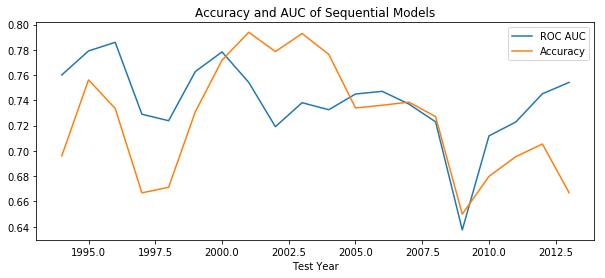

In [45]:
# test with same variables as rf_best
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))
sequential_metrics, average_cfi, sequential_results = fit_sequential_models(
    df, MODEL, 'granted', cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
    impute_methods=FULL_IMPUTE_METHODS, start_year=1994, end_year=2013, print_charts=False, print_metrics=True)

### Applying weight decay to samples

One reason could be that there are periodic shifts in sentiment such that older data might be less informative to newer cases. Let's attempt to weight recent samples more than older samples. 

In [ ]:
# try different values of alpha 

def tune_weight_decay(df, model, label, cat_features, num_features, impute_methods, start_year, end_year, weight_decay_alphas):
    results = [] 
    for alpha in weight_decay_alphas: 
        result = {} 
        metrics_summary, _, _ = fit_sequential_models(
            df, model, 'granted', cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
            impute_methods=FULL_IMPUTE_METHODS, start_year=start_year, end_year=end_year, weight_decay=alpha, 
            print_metrics=False, print_charts=False)
        result['alpha'] = alpha 
        result['average_accuracy'] = metrics_summary['Accuracy'].mean() 
        result['average_roc_auc'] = metrics_summary['ROC AUC'].mean() 
        result['average_log_loss'] = metrics_summary['Log Loss'].mean() 
        result['average_precision'] = metrics_summary['Precision'].mean() 
        result['average_recall'] = metrics_summary['Recall'].mean() 
        results.append(result)
    return pd.DataFrame(results)

In [ ]:
# find best alpha
MODEL = (RandomForestClassifier(n_estimators=20, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))
weight_decay_tuning = tune_weight_decay(df, MODEL, 'granted', cat_features=FULL_CAT_FEATURES, 
                                        num_features=FULL_NUM_FEATURES, impute_methods=FULL_IMPUTE_METHODS, 
                                        start_year=1994, end_year=2013, 
                                        weight_decay_alphas=[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
weight_decay_tuning

Training model to predict 1994 appeals...
0.9
{'Accuracy': 0.689531405782652, 'ROC AUC': 0.762088605888781, 'Log Loss': 0.5755465420654707, 'Precision': 0.6798846431146359, 'Recall': 0.4586575875486381}
Training model to predict 1995 appeals...
0.9
{'Accuracy': 0.7560082957179456, 'ROC AUC': 0.7792404948153537, 'Log Loss': 0.5211917644603679, 'Precision': 0.6995438996579247, 'Recall': 0.45444444444444443}
Training model to predict 1996 appeals...
0.9
{'Accuracy': 0.7313177983125754, 'ROC AUC': 0.7892038828182917, 'Log Loss': 0.5618335300991745, 'Precision': 0.7415329768270945, 'Recall': 0.4426709231178505}
Training model to predict 1997 appeals...
0.9
{'Accuracy': 0.665273556231003, 'ROC AUC': 0.7327555869210927, 'Log Loss': 0.6024213036891211, 'Precision': 0.6683291770573566, 'Recall': 0.46568201563857514}
Training model to predict 1998 appeals...
0.9
{'Accuracy': 0.6659340659340659, 'ROC AUC': 0.714908727271807, 'Log Loss': 0.5950671780929436, 'Precision': 0.6167304537998907, 'Recall

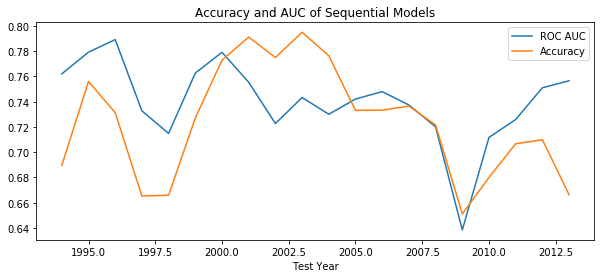

In [23]:
# choose alpha=0.9 and re-run 
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))
sequential_metrics_wt, average_cfi_wt, sequential_results_wt = fit_sequential_models(
    df, MODEL, 'granted', cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
    impute_methods=FULL_IMPUTE_METHODS, start_year=1994, end_year=2013, weight_decay=0.9, 
    print_charts=False, print_metrics=True)

In [54]:
# save sequential models as a tuple to pickle 
import pickle
from sklearn.externals import joblib 
seq_model_pkl_fname = "sequential_random_forest_vF.pkl" 
models_object = tuple([sequential_results_wt[year]['model'] for year in sequential_results_wt.keys()]) 
# with open(seq_model_pkl_fname, "wb") as f:
#     pickle.dump(models_object, f, protocol=4)

joblib.dump(models_object, seq_model_pkl_fname)

['sequential_random_forest_vF.pkl']

### Compare Feature Importances

In [55]:
# compare feature importances   
compare_cfi = pd.concat([rf_best_cfi, average_cfi_wt], axis=1)
compare_cfi.columns = ['aggregate', 'sequential']
compare_cfi['delta'] = compare_cfi['sequential'] - compare_cfi['aggregate']
compare_cfi = compare_cfi[(compare_cfi['aggregate'] > 0.01) | (compare_cfi['sequential'] > 0.01)]
compare_cfi = compare_cfi.sort_values(by='aggregate', ascending=True)

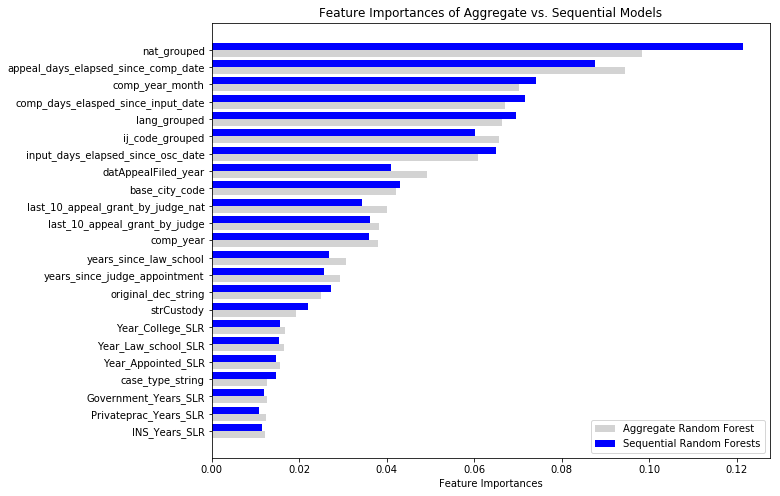

In [56]:
# plot comparison of feature importances 

ind = np.arange(len(compare_cfi))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 8)) 
agg = ax.barh(ind, compare_cfi['aggregate'], width, color='lightgrey', label='Aggregate Random Forest')
seq = ax.barh(ind+width, compare_cfi['sequential'], width, color='blue', label='Sequential Random Forests')

ax.set_xlabel('Feature Importances')
ax.set_title('Feature Importances of Aggregate vs. Sequential Models')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels((compare_cfi.index))
plt.legend(loc='best');

### Compare Accuracy and AUC 

In [26]:
# get aggregate model test accuracy and roc by year 

def summarize_perf_by_year(y_test, pred, full_data, start_year, end_year):
    
    """ Returns accuracy and roc grouped by year from aggregate model results """
    
    # join predictions back to year 
    agg_results = pd.DataFrame(y_test)
    agg_results.rename(columns={'granted': 'truth'}, inplace=True)
    agg_results['pred_proba'] = pred 
    agg_results['pred'] = (agg_results['pred_proba']>0.5).astype(int)
    agg_results = agg_results.merge(df[['datAppealFiled_year']], how='left', left_index=True, right_index=True)
    
    # loop through each year to get accuracy and auc 
    results = [] 
    for year in np.arange(start_year, end_year+1, 1): 
        result = {}
        df_year = agg_results[agg_results['datAppealFiled_year'] == year]
        result['datAppealFiled_year'] = year
        result['accuracy'] = accuracy_score(df_year['truth'], df_year['pred'])
        result['roc_auc'] = roc_auc_score(df_year['truth'], df_year['pred_proba'])
        results.append(result)

    results_df = pd.DataFrame(results).set_index('datAppealFiled_year')
    return results_df[['accuracy', 'roc_auc']]

agg_perf_by_year = summarize_perf_by_year(y_test, rf_best_pred, df, 1994, 2013)

In [29]:
perf_comparison = agg_perf_by_year.merge(sequential_metrics_wt[['Accuracy', 'ROC AUC']], 
                                         how='left', left_index=True, right_index=True)
perf_comparison.rename(columns={'accuracy': 'Accuracy (Agg)', 'roc_auc': 'ROC AUC (Agg)', 
                                'Accuracy': 'Accuracy (Seq-W)', 'ROC AUC': 'ROC AUC (Seq-W)'}, inplace=True)
perf_comparison[['Accuracy (Agg)', 'Accuracy (Seq-W)', 'ROC AUC (Agg)', 'ROC AUC (Seq-W)']]

,Accuracy (Agg),Accuracy (Seq-W),ROC AUC (Agg),ROC AUC (Seq-W)
datAppealFiled_year,,,,
1994,0.784722,0.689531,0.859230,0.762089
1995,0.821297,0.756008,0.863300,0.779240
1996,0.791452,0.731318,0.863950,0.789204
1997,0.789270,0.665274,0.862549,0.732756
1998,0.769231,0.665934,0.833339,0.714909
1999,0.790497,0.727063,0.855709,0.762704
2000,0.824263,0.772900,0.854265,0.779142
2001,0.848253,0.791231,0.843833,0.755425
2002,0.818556,0.775002,0.830476,0.722688


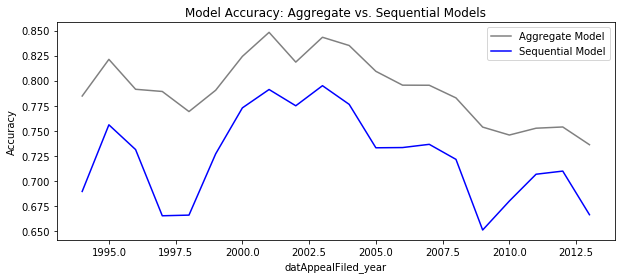

In [30]:
# compare aggregate vs. sequential 
plt.figure(figsize=(10, 4))
plt.plot(perf_comparison['Accuracy (Agg)'], color='grey', label='Aggregate Model')
plt.plot(perf_comparison['Accuracy (Seq-W)'], color='blue', label='Sequential Model')
plt.xlabel('datAppealFiled_year')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Aggregate vs. Sequential Models')
plt.legend(loc='best'); 